# **Practical Session IMA204 - Segmentation of dermoscopic images**
### Authors: Isabelle Bloch, Alasdair Newson and Pietro Gori 

# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer (more than 60k deaths in 2015 worldwide). Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (computer-aided diagnosis (CAD) ).

In this practical session, you will develop pipelines to pre-process, identify and segment skin lesions in dermoscopic images.

You will have to write code and comments where you see **XXXXXXXXXXXXXXXXXXXXX**

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) to the Site Pédagogique of IMA204 **before Sunday 19th of January 23h55**. 

**The uploaded file should be named 'YOURSURNAME_TP_IMA204.ipynb'.** 

**Please note that this is a strict deadline, if you upload your report after the deadline, it will not be evaluated.**

Let's start with downloading some dermoscopic images. You can use the following code and download them from my Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1SehoNz3SfVgpr3bNDA1reF7KL__lCEPa',
                                    dest_path='./data.zip',
                                    unzip=True)

You can list the content of the folder using the command line *!ls*

In [157]:
data_path = './data'
!ls './data'

IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png


All images are RGB images in format .jpg. You also have the corresponding ground truth (ie manual) segmentation in format .png 

In [158]:
import glob

listImages=glob.glob(data_path + '/*.jpg')
N=len(listImages)
print('There are {} images'.format(N))
print(listImages)

There are 13 images
['./data/IM_000445.jpg', './data/IM_000833.jpg', './data/IM_000215.jpg', './data/ISIC_0000001.jpg', './data/ISIC_0000046.jpg', './data/IM_000510.jpg', './data/IM_000180.jpg', './data/ISIC_0000019.jpg', './data/ISIC_0000095.jpg', './data/IM_000613.jpg', './data/ISIC_0000146.jpg', './data/IM_000407.jpg', './data/ISIC_0000042.jpg']


Let's plot one image with the corresponding segmentation

Text(0.5, 1.0, 'Image with mask')

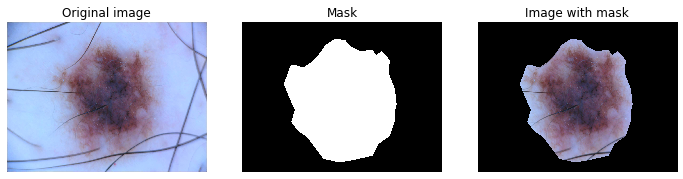

In [159]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Choose a figure and plot it with the ground truth segmentation
indexIm=12
filename = listImages[indexIm]
im = imread(filename)
filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg_bool = (im_Seg/max(im_Seg.flatten())).astype(np.uint8) # To get uint8
im_Seg_expand = np.expand_dims(im_Seg_bool, axis=2)
im_mul_mask = (im_Seg_expand*im) # pixel-wise product

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(im_Seg,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(im_mul_mask)
grid[2].axis('off')
grid[2].set_title("Image with mask")

First, let's simplify the problem by using only the blue channel and rescaling the figure

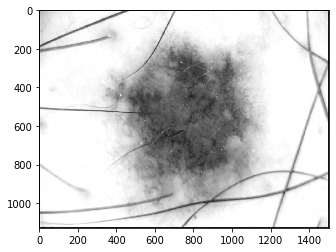

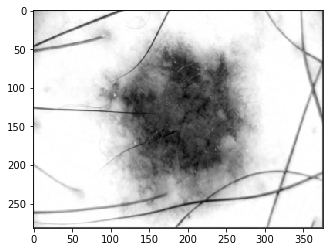

In [160]:
from skimage.transform import rescale
from skimage import img_as_bool

# We only select the blue channel to start
imb=im[:,:,2]
plt.figure()
plt.imshow(imb,cmap='gray')
plt.show()

# We rescale to speed up computations
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
im_Seg_r_bool = (im_Seg_r/max(im_Seg_r.flatten())).astype(np.uint8)

plt.figure()
plt.imshow(imbr,cmap='gray') 
plt.show()

Now, let's try to use K-means to directly segment the image. We will use the scikit-learn implementation.

Text(0.5, 1.0, 'Ground Truth Segmenation')

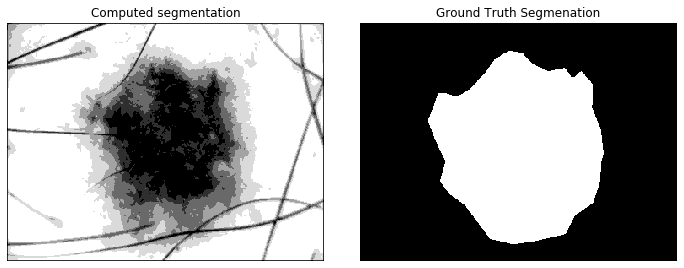

In [161]:
from sklearn.cluster import KMeans

Ncluster=6

x, y = imbr.shape
imFloat = np.array(imbr, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
if Ncluster==2: # make kmeansSeg boolean
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 0  
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 1

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(kmeansSeg,cmap='gray')
grid[0].axis('off')
grid[0].set_title("Computed segmentation")
grid[1].imshow(im_Seg_r_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Ground Truth Segmenation")


To quantitavely compare the two segmentations, we can use the Dice score defined as $DSC=\frac{2TP}{2TP+FP+FN}$ for boolean data. First, we should check that the computed segmentation mask is coherent with the ground truth

The dice similarity is  0.7951524599317237


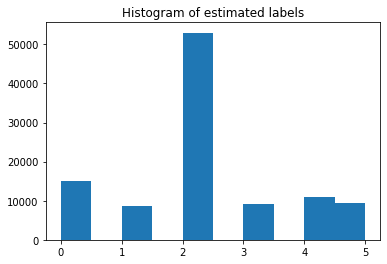

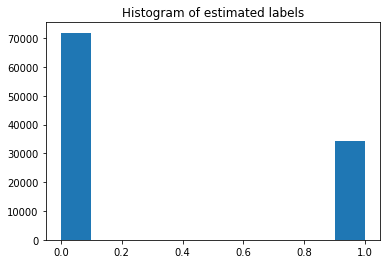

In [162]:
from scipy.spatial.distance import dice

plt.figure()
plt.hist(cluster_labels)
plt.title('Histogram of estimated labels')

plt.figure()
plt.hist(im_Seg_r_bool.flatten())
plt.title('Histogram of estimated labels')

print('The dice similarity is ', 1-dice(cluster_labels,im_Seg_r_bool.flatten()))


Try to change the number of clusters, can you correctly segment the skin lesion ? 
Quand on change le nombre de cluster, dans l'objectif d'obtenir une classe pour le grain de beauté et une autre pour les poils, on remarque que le coefficient de similarité est le plus élevé pour k=2. Il augmente entre k=3 et k=5, mais les résultats restent moins bon qu'une division en deux classes, car non seulement les poils ne sont pas segmentés dans une classe à part, mais le grain de beauté est aussi souvent séparé en plusieurs classes quand k>2.

As you can see, there are several hairs within and outside the skin lesion image. One would like to remove and restore the hair regions to effectively segment and analyze the lesions. 

The first goal of this practical session will be to remove the hair. You will use morphological operators, interpolation techniques and filter as seen in the previous lectures. 

# Mathematical Morphology
Here, we will remind you some morphological operators that you could use to remove the hair and segment the lesion. Please note that the structural elements and the hyper-parameters have been randomly chosen... you should probably change them.

In [0]:
import skimage.morphology as morpho  

def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

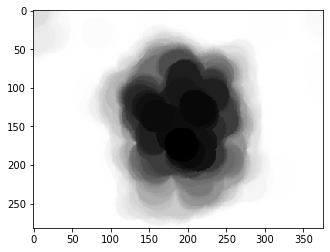

In [164]:
#fermeture par un disque
sizeDisque=20
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)
plt.figure()
plt.imshow(closeDisk,cmap='gray')
plt.show()

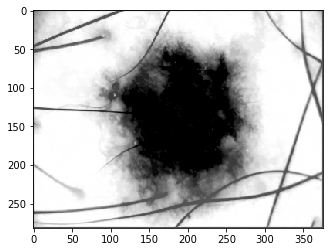

In [165]:
# Reconstruction par erosion
RecEr=np.max(imbr) - morpho.reconstruction(np.max(imbr)-closeDisk,np.max(imbr)-imbr)
plt.figure()
plt.imshow(RecEr,cmap='gray')
plt.show()


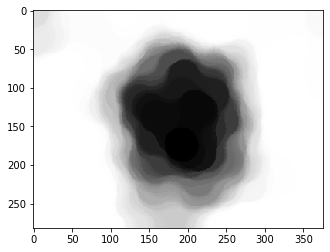

In [166]:
# Overture (remove small bright parts)
N=20
se=strel('disk',N)
Open=morpho.opening(closeDisk,se)
plt.figure()
plt.imshow(Open,cmap='gray')
plt.show()

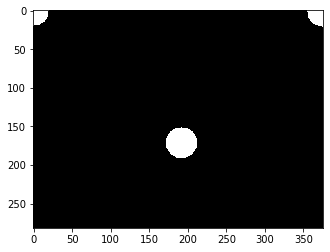

In [167]:
# Minima regionaux
maxIm=255
temp=Open.copy()
    
for i in range(Open.shape[0]):
    for j in range(Open.shape[1]):
        if Open[i,j] < maxIm: 
            temp[i,j]=Open[i,j]+1
reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Open)
minReg=np.uint8(reco)-Open
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

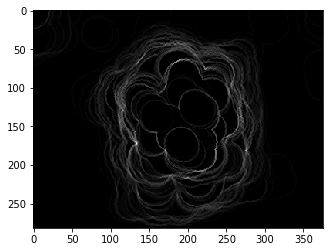

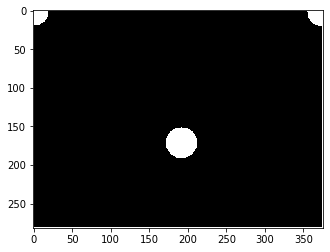

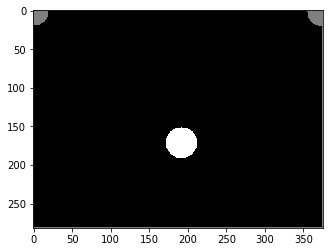

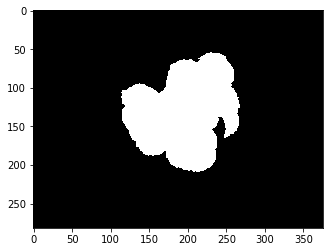

In [168]:
from scipy import ndimage as ndi

#segmentation par ligne de partage des eaux avec marqueurs

#gradient morphologique de l'image initiale
se=strel('disk',1)
grad=morpho.dilation(closeDisk,se)-morpho.erosion(closeDisk,se)
plt.figure()
plt.imshow(grad,cmap='gray')
plt.show()

#suppression des marqueurs trop petits
tailleMin=20
seM=strel('disk',tailleMin)
minReg=morpho.opening(minReg,seM)

#ajout d'un marqueur sur le bord de l'image
for i in range(minReg.shape[0]):
    minReg[i,0]=1
    minReg[i,minReg.shape[1]-1]=1
for j in range(minReg.shape[1]):
    minReg[0,j]=1
    minReg[minReg.shape[0]-1,j]=1
    
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

markers = ndi.label(minReg)[0]
plt.figure()
plt.imshow(markers,cmap='gray')
plt.show()

def composante(labels):
  count=[]
  val=[]
  for i in range(len(labels)):
    for j in range(len(labels[0])):
      if labels[i][j] in val:
        count[val.index(labels[i][j])]+=1
      else:
        val.append(labels[i][j])
        count.append(1)
  if len(count)==1:
    return(labels)
  fond=count.index(max(count))
  count.pop(fond)
  val.pop(fond)
  tache=count.index(max(count))
  couleur_tache=val[tache]
  return(labels==couleur_tache)

labels = composante(morpho.watershed(grad, markers))
plt.figure()
plt.imshow(labels,cmap='gray')
plt.show()

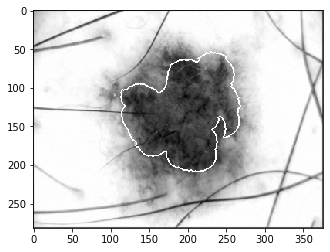

The dice similarity is  0.6304160401002507


In [169]:
#%% visualiation du resultat
se=strel('disk',1)
segm=labels.copy()

segm=ndi.binary_fill_holes(segm).astype(int)
#NB: ce resultat peut servir d'initialisation pour une autre methode de segmentation (croissance de regions, segmentation markovienne, etc.)

#superposition des contours de la segmentation a l'image initiale
contour=morpho.dilation(segm,se)-morpho.erosion(segm,se)
contourSup=np.maximum(contour*255,imbr)
plt.figure()
plt.imshow(contourSup,cmap='gray')
plt.show()       

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))


**Question**: Using the previous methods (and other if you wish), propose a pipeline to correctly segment the lesions of at least two different images. 

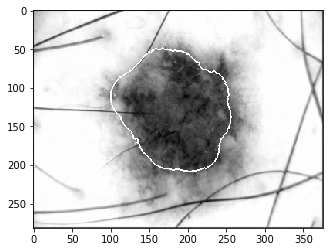

The dice similarity is  0.6805689395983503


In [170]:
#Choix image et paramètres
sizeDisqueOuv=10
sizeDisqueFerm=30
tailleMin=10

# Ouverture (remove small bright parts)
se=strel('disk',sizeDisqueOuv)
Open=morpho.opening(imbr,se)

#fermeture par un disque
disk=strel('disk',sizeDisqueFerm)
Close=morpho.closing(Open,disk)

#Calcul Gradient
se=morpho.selem.disk(1)
grad=morpho.dilation(Close,se)-morpho.erosion(Close,se)

# Minima regionaux
maxIm=255
temp=Close.copy()  
for i in range(Close.shape[0]):
    for j in range(Close.shape[1]):
        if Open[i,j] < maxIm: 
            temp[i,j]=Close[i,j]+1
reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Close)
minReg=np.uint8(reco)-Close

#suppression des marqueurs trop petits
seM=strel('disk',tailleMin)
minReg=morpho.opening(minReg,seM)

#ajout d'un marqueur sur le bord de l'image
for i in range(minReg.shape[0]):
    minReg[i,0]=1
    minReg[i,minReg.shape[1]-1]=1
for j in range(minReg.shape[1]):
    minReg[0,j]=1
    minReg[minReg.shape[0]-1,j]=1
markers = ndi.label(minReg)[0]

#Watershed et selection de la composante 
labels = composante(morpho.watershed(grad, markers,watershed_line=True))
segm_morpho=labels.copy()
segm_morpho=ndi.binary_fill_holes(segm_morpho).astype(int)

#Création des contours
se=strel('disk',1)
contour=morpho.dilation(segm_morpho,se)-morpho.erosion(segm_morpho,se)
contourSup=np.maximum(contour*255,imbr)

#Affichage
plt.figure()
plt.imshow(contourSup,cmap='gray')
plt.show()       

print('The dice similarity is ', 1-dice(segm_morpho.flatten(),im_Seg_r_bool.flatten()))


J'ai choisi de réaliser l'ouverture avant la fermeture, les résultats étant meilleurs pour les grains de beautés étendus et dont les contours sont peu marqués (exemple : image 5 ou 6). En effet, avec l'ouverture on détecte une zone "incluse" dans le grain de beauté, dont nous sommes surs qu'elle fait partie de la zone à détecter, puis une fermeture, pour obtenir le grain de beauté complet.
 La forme du disque me semble plus approrpiée pour réaliser des calculs morphologiques sur les grains de beautés, j'ai fixé la taille à 20, pour ne pas prendre en compte les détails mais tout de même bien détecter le contour du grain de beauté.  
J'ai choisi d'implémenter la fonction composante, qui sélectionne la plus grande composante connexe obtenue après le Watershed.
J'ai testé l'algorithme en utilisant le minimum de gradient comme marqueurs pour le watershed , sans succès, le grain de beauté détecté ne correpond pas dutout à l'image.

## DullRazor


One of the simplest algorithms for Hair Removal is DullRazor proposed by Lee et al. It consists of three steps: (1) identiication of the hair using morphological closing operation; (2) replacement of the hair pixels with normal (close) skin pixels using bilinear interpolation; and (3) smoothing the final result with a median filter.

---

*T.K. Lee, V. Ng, R. Gallagher, A. Coldman, D. McLean, A Dullrazor, Software approach to hair removal from images, J. Comput. Biol. Med. 27 (1997) 533–543*


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


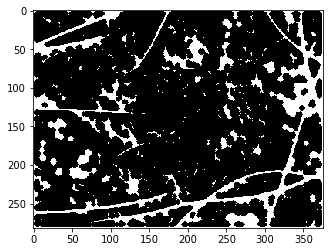

In [171]:
def mask_poils(im):
  line1=strel('line',20,angle=90)
  line2=strel('line',20,angle=45)
  line3=strel('line',20,angle=0)
  line4=strel('line',20,angle=22.5)
  line5=strel('line',20,angle=67.5) #On teste autant d'orientations possibles pour détecter le plus de poils possibles
  Close3=morpho.closing(im,line3)
  Close2=morpho.closing(im,line2)
  Close1=morpho.closing(im,line1)
  Close4=morpho.closing(im,line4)
  Close5=morpho.closing(im,line5)
  masque_poils=im.copy()
  se=strel('disk',3)
  masque_poils=morpho.opening(masque_poils,se)
  for i in range(len(masque_poils)):
    for j in range(len(masque_poils[0])):
      masque_poils[i][j]=max(0,masque_poils[i][j]-max(Close1[i][j],Close2[i][j],Close3[i][j],Close4[i][j],Close5[i][j])) #On masque les portions de l'image représentant des poils
  se=strel('disk',3)
  mask=(masque_poils<210)#on seuille l'image pour créer le masque
  mask=morpho.closing(mask,se)
  return mask

#affichage
mask=mask_poils(imbr)
plt.imshow(mask,cmap='gray')
plt.show()

Once computed a mask identifying the hair, we need to replace the hair pixels with close skin pixels. We could use an interpolation scheme using, for instance, scipy.interpolate or np.interp. Or a more advanced solution based on inpaiting (recommended, you will see it in IMA206) such as: 

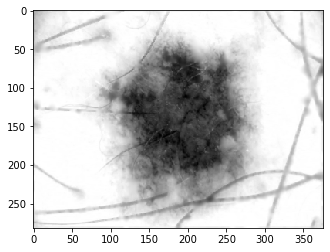

In [172]:
from skimage.restoration import inpaint
image_result = inpaint.inpaint_biharmonic(imbr, mask, multichannel=False)
plt.imshow(image_result,cmap="gray")

Eventually, authors suggest to use a median filter to smooth the results. 

Text(0.5, 1.0, 'image avec filtre')

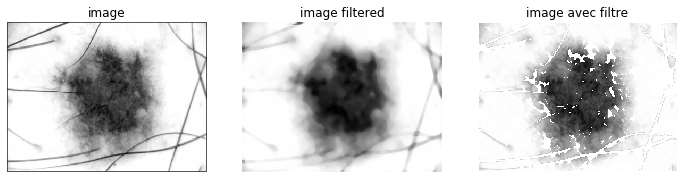

In [173]:
from scipy import ndimage

medianFilt = ndimage.median_filter(imbr, size=10)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(medianFilt,cmap='gray')
grid[1].axis('off')
grid[1].set_title("image filtered")
grid[2].imshow([[max(imbr[i][j],mask[i][j]*255) for j in range(len(imbr[0]))]for i in range(len(imbr))],cmap='gray')
grid[2].axis('off')
grid[2].set_title("image avec filtre")


**Question**: Implement the original (or a modified version) of the DullRazor algorithm. If you modify the algorithm, please explain why. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


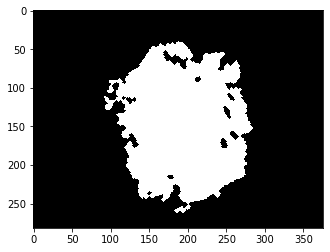

The dice similarity is  0.8776322905229348


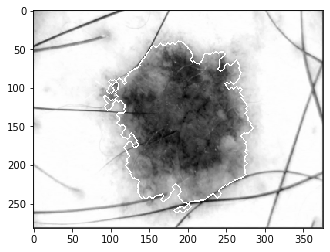

In [174]:

def dullRazor(img):
  se=strel('disk',2)
  mask=mask_poils(img)
  im_mask=np.array([[max(img[i][j],mask[i][j]*255) for j in range(len(img[0]))]for i in range(len(img))])#on recouvre les poils de blanc grâce au masque trouvé précedemment
  im_mask=morpho.closing(im_mask,se)#On comble les trous générés dans le grain de beauté
  best_image=np.zeros((len(img),len(img[0])))
  image_result=np.zeros((len(img),len(img[0])))
  best_dice=0
  for seuil in range(50,200): # On cherche la meilleure valeur pour seuiller l'image
    image_result[im_mask<seuil]=1
    image_result=ndi.label(morpho.closing(image_result,se))[0]#Décomposition en composantes connexes, après avoir de nouveau réalisé une fermeture pour combler les trous causés par le seuillage
    image_result=composante(image_result)#on choisit la plus grande composante connexe
    dice_sim=1-dice(image_result.flatten(),im_Seg_r_bool.flatten())
    if dice_sim>best_dice:
      best_dice=dice_sim
      best_image=image_result.copy()
  return best_image,mask

segm=dullRazor(imbr)[0]

#Affichage
plt.imshow(segm,cmap='gray')
plt.show()
print('The dice similarity is ',1-dice(segm.flatten(),im_Seg_r_bool.flatten()))
se=strel('disk',1)
segm=ndi.binary_fill_holes(segm).astype(int)
contour=np.array(morpho.dilation(segm,se)-morpho.erosion(segm,se))
contourSup=np.maximum(contour*255,imbr)
plt.figure()
plt.imshow(contourSup,cmap='gray')
plt.show() 

L'algorithme de Inpainting est très long et peu efficace, j'ai donc choisi de ne pas l'utiliser. J'ai choisi de recouvrir les poils de blanc, puis de seuiller l'image. Ainsi, seul le grain de beauté est détecté. Il faut réaliser une fermeture au début de l'algorithme pour combler les zones blanches à l'intérieur du grain de beauté. 
Pour choisir le meilleur seuil, on les teste tous, et on choisit celui permettant d'obtenir le meilleur résultat. On décompose ensuite l'image en composantes connexes puis en sélectionne uniquement la plus grand composante. 
Le résultat final est meilleur que celui obtenu en utilisant le Inpainting.



## Otsu's algorithm

Otsu's method looks for a threshold to split a gray-level image into two separate regions, based on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the intra-class intensity variance, defined as a weighted sum of the variances of the two regions :

$argmin_{\tau}  \omega_0(\tau)\sigma_0^2(\tau) + \omega_1(\tau)\sigma_1^2(t)$

where

- $\sigma_0^2(\tau)$ and $\sigma_1^2(\tau)$ are the intensity variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are the weights of the first and second regions 

Given the histogram of the image with $L$ bins where each bin $i$ has $p(i)$ pixels, we define the weights $\omega_0(\tau)$ and $\omega_1(\tau)$ as:

- $\omega_0(\tau) = \sum_{i=0}^{\tau -1} p(i)$
- $\omega_1(\tau) = \sum_{i = \tau}^{L-1} p(i)$


**Question**: Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image has only 256 discrete values. Choose the threshold values accordingly.

In [0]:
def segmentation_otsu(img):

    min_sigma = np.float('inf')
    tau_out = 0
    min_level = 0.0
    max_level = 255.0
    n_levels = 256
    for tau in np.linspace(min_level, max_level,n_levels):
        # first, get weights of the two regions
        omega_0 = np.sum(img<=tau)
        omega_1 = np.sum(img>tau)

        # only analyse thresholds which give two non-empty regions
        if omega_0!=0 and omega_1!=0:

            sigma_0 = np.sqrt(np.var(img[img<=tau]))
            sigma_1 = np.sqrt(np.var(img[img>tau]))

            sigma_total = omega_0*sigma_0 + omega_1*sigma_1

            if (sigma_total < min_sigma):
                tau_out = tau
                min_sigma = sigma_total

    img_out = np.zeros((img.shape[0],img.shape[1]))
    img_out[img<tau_out] = 1
    return img_out,tau_out

You can apply the Otsu method to segment previously pre-processed images.

The best threshold is 196.0
The dice similarity is  0.8519025853243551


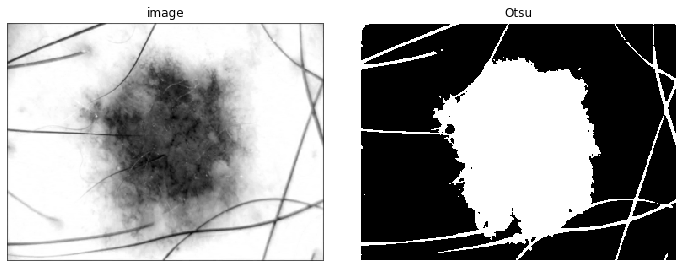

In [176]:
Otsu,tau = segmentation_otsu(imbr)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(Otsu,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Otsu")

print('The best threshold is {}'.format(tau))
print('The dice similarity is ', 1-dice(Otsu.flatten(),im_Seg_r_bool.flatten()))


One of the problem of the Otsu method it's that there is no notion of connectivity (two regions far away can be in the same region). For such a notion, we turn to region merging.

De plus, l'algorithme ne permet pas de distinguer les poils du grain de beauté. 

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [0]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init

Now, we can create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

In [0]:
from scipy.ndimage import binary_dilation

def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    nbhood = np.asarray( [ [0,1,0],[1,1,1],[0,1,0]] )

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = binary_dilation(seg_n, structure=nbhood).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img-avg ) < tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n,seg_init

**Question**: Carry out the segmentation on the previously pre-processed images with the seed point and threshold specified in the following code. The proposed implementation is very simple. We could definitely improve it. Do you see how ? You can simply explain how you would do it or, if you have time, even try to implement it. 

The best tau is 80
The dice similarity is  0.8666539799913006


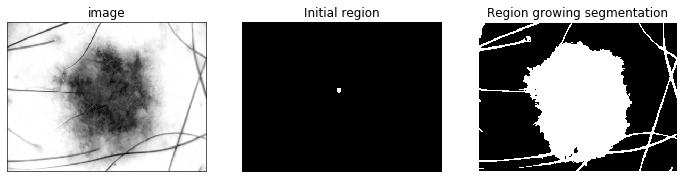

In [179]:
#Pour choisir seed, prenons le centre du grain de beauté détecté à l'aide des transformations morphologiques
xo=0
yo=0
for i in range(len(segm_morpho)):
  for j in range(len(segm_morpho[0])):
    if segm_morpho[i][j]>0:
      xo+=i
      yo+=j
xo=int(xo/np.sum(segm_morpho>0))
yo=int(yo/np.sum(segm_morpho>0))

#On teste différentes valeurs de tau, et on choisit la meilleure
seed_pt = np.asarray([xo,yo])
best_tau=-1
best_dice=0
for tau in range(0,100):
  img_out_region_growing,seg_init = segmentation_region_growing(imbr,seed_pt,tau)
  dice_sim=1-dice(img_out_region_growing.flatten(),im_Seg_r_bool.flatten())
  if dice_sim>best_dice:
    best_dice=dice_sim
    best_tau=tau

#Affichage
img_out_region_growing,seg_init = segmentation_region_growing(imbr,seed_pt,best_tau)
fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")
print('The best tau is', str(best_tau))
print('The dice similarity is ', 1-dice(img_out_region_growing.flatten(),im_Seg_r_bool.flatten()))


Il faut choisir une origine qui se trouve à l'intérieur du grain de beauté. Pour ca, on peut utiliser un résultat précédent (dans notre cas, la moyenne de tous les points compris dans la  tache obtenue grâce à la première méthode, utilisant les transformations morphologiques). Pour trouver le meilleur tau, on parcourt un ensemble de valeur, jusqu'à trouver celui qui donne le meilleur résultat. Pour encore améliorer l'algorithme nous pourrions utiliser le masque de poils vu dan DullRazor, pour éviter les zones de poils de merger avec le grain de beauté.

# Graph-Cut
You can also use graph-cut, as seen in the previous lecture, to segment the image or to remove hair. You could, for instance, see the hair as noise and try to remove it using the gaussian model or the one of Potts.

Here, you can find an example of binary segmentation.

**Question**: propose a pipeline, based on graph-cuts and other pre-processing or post-processing methods, to correctly segment the images.

In [180]:
!pip install PyMaxflow
import maxflow

The dice similarity is  0.2841396718552798


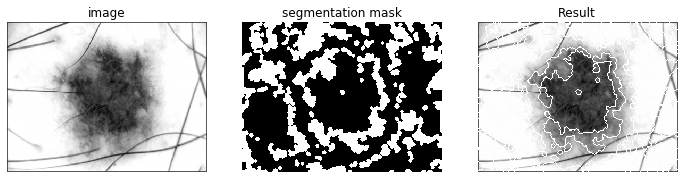

In [181]:
#Définition arbitraire des moyennes
m1 = 70
m2 = 140

#On teste différentes valeurs de beta pour choisir la meilleure
best_im=imbr.copy()
best_dice=0
for beta in range(00,200,10):
  ## Graph cut binaire
  g = maxflow.Graph[float]()
  nodeids = g.add_grid_nodes(imbr.shape)
  g.add_grid_edges(nodeids, beta)
  g.add_grid_tedges(nodeids, (imbr-m1)**2, (m2-imbr)**2)
  flow = g.maxflow()
  sgm = g.get_grid_segments(nodeids)
  im_bin = 1 - np.int_(np.logical_not(sgm))
  segm=morpho.closing(im_bin,strel('disk',3))#fermeture pour combler les trous 
  labels=ndi.label(segm)[0]#labellisation
  label=composante(labels)#selection de la plus grande composante connexe
  dice_test=1-dice(label.flatten(),im_Seg_r_bool.flatten())
  if dice_test>best_dice:
    best_dice=dice_test
    best_im=label.copy()

#Affichage
fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
segm=ndi.binary_fill_holes(best_im).astype(int)
contour=np.array(morpho.dilation(segm,se)-morpho.erosion(segm,se))
contourSup=np.maximum(contour*255,imbr)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(segm,cmap='gray')
grid[1].axis('off')
grid[1].set_title("segmentation mask")
grid[2].imshow(contourSup,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Result")

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))


On peut trouver beta en parcourant un ensemble de valeurs, cependant il est difficile de trouver les valeurs de m1 et m2 les moyennes de couleur. Pour palier à ce défaut, on peut de nouveau utiliser les résultats des présédentes méthodes pour obtenir les moyennes en question.
Le Graphcut naïf est donc peu efficace.
Cependant, nous pouvons améliorer l'algorithme Graphcut, comme nous pouvons le voir ci-dessous :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


The dice similarity is  0.8101137888371931


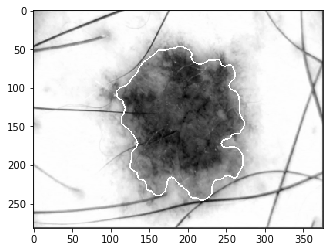

In [186]:
#Trouver les valeurs de m1 et m2 grâce à DullRazor
mask=mask_poils(imbr)
im_sans_poils=np.array([[max(imbr[i][j],poils[i][j]*255) for j in range(len(imbr[0]))]for i in range(len(imbr))])
im_sans_poils=ndimage.median_filter(im_sans_poils, size=3)
m1=0
m2=0
for i in range(len(im_sans_poils)):
  for j in range(len(im_sans_poils[0])):
    if segm_morpho[i][j]==0:
      m2+=im_sans_poils[i][j]
    else:
      m1+=im_sans_poils[i][j]
m2=int((m2/np.sum(mask==0)))
m1=int((m1/np.sum(mask>0)))

#Moyenneur
#im_sans_poils = ndimage.median_filter(im_sans_poils, size=10)

#Parcourir selon les valeurs de beta
best=im_sans_poils
best_dice=0
for beta in range(1000,2000,50):
  ## Graph cut binaire
  g = maxflow.Graph[float]()
  nodeids = g.add_grid_nodes(im_sans_poils.shape)
  g.add_grid_edges(nodeids,beta)
  g.add_grid_tedges(nodeids, (im_sans_poils-m1)**2, (m2-im_sans_poils)**2)
  flow = g.maxflow()
  sgm = g.get_grid_segments(nodeids)
  im_bin = 1 - np.int_(np.logical_not(sgm))
  labels=ndi.label(morpho.closing(sgm,strel("disk",5)))[0]#fermeture pour combler les trous, labellisation
  label=composante(labels)#selection de la plus grande composante
  dice_test=1-dice(label.flatten(),im_Seg_r_bool.flatten())
  if dice_test>best_dice:
    best_dice=dice_test
    best=label.copy()

#Affichage
segm=ndi.binary_fill_holes(best).astype(int)
print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))
contour=np.array(morpho.dilation(segm,se)-morpho.erosion(segm,se))
contourSup=np.maximum(contour*255,imbr)
plt.imshow(contourSup,cmap='gray')
plt.show()

Pour que l'algorithme GraphCut soit efficace, il faut choisir les moyennes m1 et m2 pour chaque image. Pour cela nous devons utiliser un algorithme permettant de localiser la tache, et uniquement la tache. J'ai décidé d'utiliser l'algorithme de prendre le masque de poils utilisé dans DullRazor, et d'utiliser le masque obtenu morphologiquement pour calculer les moyennes de couleur m1 et m2. En effet, les poils sont de la couleur du grain de beauté, et l'algorithme de Graph_Cut pourrait couper les zones sombres des poils dans la même classe que le grain de beauté. On cache donc les poils avec un filtre blanc, on peut éventuellement moyenner l'image. On essaie de nouveau de trouver le beta le plus efficace en parcourant un ensemble de valeurs (si l'algorithme est trop long, on peut fixer beta=1700). On utilise les morphologies mathématiques notamment après le graphcut et avant la labellisation en composante connexe pour éviter l'apparition de "trous" dans le grain de beauté. Enfin, nous labellisons en composantes connexes, puis choisissons la plus grande composante. 

